In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.models import vgg

from sklearn import preprocessing
from torchsummary import summary
from tqdm.notebook import tqdm
from collections import namedtuple

import time
import random
import os
import collections

In [ ]:
class CNN(nn.Module):
    def __init__(self):

        super(CNN, self).__init__()
        self.conv3d_1 = nn.Conv3d(1, 16, kernel_size=3, stride=1)
        self.tanh_1 = nn.Tanh()
        self.bn1 = nn.BatchNorm3d(16)
        self.drop_1 = nn.Dropout(0.25)
        self.conv3d_2 = nn.Conv3d(16, 32, kernel_size=2, stride=1)
        self.tanh_2 = nn.Tanh()        
        self.bn2 = nn.BatchNorm3d(32)
        self.drop_2 = nn.Dropout(0.25)
        self.conv3d_3 = nn.Conv3d(32, 64, kernel_size=2, stride=1)
        self.tanh_3 = nn.Tanh()
        self.bn3 = nn.BatchNorm3d(64)
        self.drop_3 = nn.Dropout(0.25)
        self.flat_1 = nn.Flatten()
        self.lin_1 = nn.Linear(64*19*226, 33*40)
        self.lambda_1 = Lambda(lambda x: x.view(x.size(0), -1))


    def forward(self, x):

        x = self.conv3d_1(x)
        x = self.tanh_1(x)
        x = self.bn1(x)
        x = self.drop_1(x)
        x = self.conv3d_2(x)
        x = self.tanh_2(x)
        x = self.bn2(x)
        x = self.drop_2(x)
        x = self.conv3d_3(x)
        x = self.tanh_3(x)
        x = self.bn3(x)
        x = self.drop_3(x)
        x = self.flat_1(x)
        x = self.lin_1(x)
        y_pred = self.lambda_1(x)
        return y_pred

In [ ]:
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

In [ ]:
# Generator
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))


In [ ]:
# Custom view layer
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


In [ ]:
def loss_batch(cnn, loss_network, loss_func, xb, yb, opt=None):

    xb = Variable(xb.data, requires_grad=True)

    cnn_output = torch.reshape(cnn(xb), (-1,33,40)).unsqueeze(1)
    cnn_output = cnn_output.repeat(1,3,1,1)

    features_pred_labels = loss_network(cnn_output)
    features_labels = loss_network(yb)

    with torch.no_grad():
        f_labels = features_labels[1].detach()

    loss = loss_func(features_pred_labels[1], f_labels)

    if opt != None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
# Fit model
def fit(epochs, cnn, loss_network, loss_func, opt, train_dl, valid_dl, batches, verbose):
    train_losses = []
    validation_losses = []
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
      
        batch = 1
        
        cnn.train()

        loss = 0

        # With progress bar
        if verbose == 1:
            for xb, yb in tqdm(train_dl):
                batch_loss, batch_size = loss_batch(cnn, loss_network, loss_func, xb, yb, opt)
                loss += batch_loss                
                print('{}/{}'.format(batch, batches), end="\r")
                batch+=1

        # Without progress bar
        if verbose == 2:
            for xb, yb in train_dl:
                batch_loss, batch_size = loss_batch(cnn, loss_network, loss_func, xb, yb, opt)
                loss += batch_loss                
                print('{}/{}'.format(batch, batches), end="\r")
                batch+=1

        loss=loss/batch

        cnn.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(cnn, loss_network, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        train_losses.append(loss)
        validation_losses.append(val_loss)

        print('loss = {}      val_loss: {}'.format(loss, val_loss))

    return train_losses, validation_losses

In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 5, 23, 230).to(dev), y.to(dev)

In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [ ]:
# NRMSE loss function
def nrmse_loss(y_pred, y_true):
    diff = torch.div(y_pred - y_true, torch.max(y_true) - torch.min(y_true) + 1e-6)
    # diff = torch.div(y_pred - y_true, y_true + 1e-31)
    return torch.sqrt(torch.mean(torch.square(diff)))

In [ ]:
# Load dataset created from notebook 'Debias_Data_Cosima'
t_data = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/twenty_training_data.npz', allow_pickle=True)
v_data = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/twenty_val_data.npz', allow_pickle=True) 

training_data = t_data['arr_0'] # saves the array from t_data file
print(training_data.shape)

val_data = v_data['arr_0'] 
print(val_data.shape)

# This part reorganises the array into input and label arrays, mainly to help it feed into model with correct shapes
# For training data
train_X = []
train_Y = []

for i in range (len(training_data)):
  train_X.append(training_data[i][0])
  train_Y.append(training_data[i][1])

train_X = np.array(train_X)
train_Y = np.array(train_Y)

# For validation data
val_X = []
val_Y = []

for i in range (len(val_data)):
  val_X.append(val_data[i][0])
  val_Y.append(val_data[i][1])

val_X = np.array(val_X)
val_Y = np.array(val_Y)

# Add axis to training and validation arrays
train_X = train_X[:, :, :, np.newaxis]
val_X = val_X[:, :, :, np.newaxis]

# Standardise data for vgg
scaler = preprocessing.StandardScaler()
train_Y = scaler.fit_transform(np.squeeze(train_Y))
val_Y = scaler.fit_transform(np.squeeze(val_Y))
print(train_Y.shape)

# # Repeat along 3 dimensions to replicate RGB for vgg
train_Y = np.repeat(train_Y[:, np.newaxis, :], 3, axis=1)
val_Y = np.repeat(val_Y[:, np.newaxis, :], 3, axis=1)

# Make array >32 pixels high for vgg
train_Y = np.repeat(train_Y[:, :, :, np.newaxis], 3, axis=2)
val_Y = np.repeat(val_Y[:, :, :, np.newaxis], 3, axis=2)
print(train_Y.shape)
print(val_Y.shape)

# # Make array 32 pixels wide for vgg
# train_Y = np.repeat(train_Y[:, :, :, :], 32, axis=3)
# val_Y = np.repeat(val_Y[:, :, :, :], 32, axis=3)
# print(train_Y.shape)
# print(val_Y.shape)


train_X = np.reshape(train_X, (-1,1,23,230,5))
val_X = np.reshape(val_X, (-1,1,23,230,5))
train_Y = np.reshape(train_Y, (-1,3, 33, 10))
train_Y = np.repeat(train_Y[:, :, :, :], 4, axis=3)
val_Y = np.reshape(val_Y, (-1,3, 33, 10))
val_Y = np.repeat(val_Y[:, :, :, :], 4, axis=3)

# Check correct shape
print(train_X.shape, train_Y.shape)
print(val_X.shape, val_Y.shape)


(7680, 2)
(1200, 2)
(7680, 11)
(7680, 3, 33, 1)
(1200, 3, 33, 1)
(768, 1, 23, 230, 5) (768, 3, 33, 40)
(120, 1, 23, 230, 5) (120, 3, 33, 40)


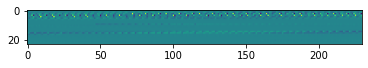

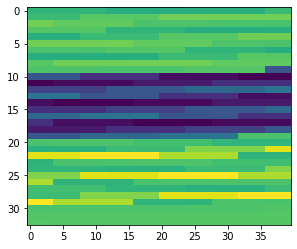

In [ ]:
plt.imshow(train_X[60, 0, :, :, 0])
plt.show()
plt.imshow(train_Y[60, 0, :, :])
plt.show()

In [ ]:
# PyTorch uses tensors
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (train_X, train_Y, val_X, val_Y)
)

# Data must be stored on GPU to use GPU for training
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
x_train, y_train = x_train.to(dev), y_train.to(dev)
x_valid, y_valid = x_valid.to(dev), y_valid.to(dev)

print(x_train.shape, y_train.shape)

# Batch size
bs = 64

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

torch.Size([768, 1, 23, 230, 5]) torch.Size([768, 3, 33, 40])


In [ ]:
# # CNN model
cnn = CNN()

# Store model on GPU for training
cnn.to(dev)

# Model summary
summary(cnn, input_size=(1, 5, 23, 230))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 3, 21, 228]             448
              Tanh-2       [-1, 16, 3, 21, 228]               0
       BatchNorm3d-3       [-1, 16, 3, 21, 228]              32
           Dropout-4       [-1, 16, 3, 21, 228]               0
            Conv3d-5       [-1, 32, 2, 20, 227]           4,128
              Tanh-6       [-1, 32, 2, 20, 227]               0
       BatchNorm3d-7       [-1, 32, 2, 20, 227]              64
           Dropout-8       [-1, 32, 2, 20, 227]               0
            Conv3d-9       [-1, 64, 1, 19, 226]          16,448
             Tanh-10       [-1, 64, 1, 19, 226]               0
      BatchNorm3d-11       [-1, 64, 1, 19, 226]             128
          Dropout-12       [-1, 64, 1, 19, 226]               0
          Flatten-13               [-1, 274816]               0
           Linear-14                 [-

In [ ]:
LossOutput = namedtuple("LossOutput", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])
vgg_model = vgg.vgg16(pretrained=True)
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vgg_model.to(dev)
loss_network = LossNetwork(vgg_model)
loss_network.eval()

summary(loss_network, input_size=(3,33,40))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 33, 40]           1,792
              ReLU-2           [-1, 64, 33, 40]               0
            Conv2d-3           [-1, 64, 33, 40]          36,928
              ReLU-4           [-1, 64, 33, 40]               0
         MaxPool2d-5           [-1, 64, 16, 20]               0
            Conv2d-6          [-1, 128, 16, 20]          73,856
              ReLU-7          [-1, 128, 16, 20]               0
            Conv2d-8          [-1, 128, 16, 20]         147,584
              ReLU-9          [-1, 128, 16, 20]               0
        MaxPool2d-10           [-1, 128, 8, 10]               0
           Conv2d-11           [-1, 256, 8, 10]         295,168
             ReLU-12           [-1, 256, 8, 10]               0
           Conv2d-13           [-1, 256, 8, 10]         590,080
             ReLU-14           [-1, 25

In [ ]:
loss_func = nrmse_loss
learning_rate = 1e-3
EPOCHS = 200
batches = math.ceil(len(x_train)/bs)
verbose = 2       # 1: progress bar, 2: without progress bar

opt = optim.Adam(cnn.parameters(), lr=learning_rate)

train_losses, val_losses = fit(EPOCHS, cnn, loss_network, loss_func, opt, train_dl, valid_dl, batches, verbose)

torch.save(cnn.state_dict(), '/content/drive/My Drive/ML_Ultrasound_Project/cnn_state_dict')

Epoch 1/200
loss = 0.1656578274873587      val_loss: 0.035078879445791245
Epoch 2/200
loss = 0.16879412761101356      val_loss: 0.05866219103336334
Epoch 3/200
loss = 0.16750349906774667      val_loss: 0.09089198708534241
Epoch 4/200
loss = 0.17299189590490782      val_loss: 0.12266992032527924
Epoch 5/200
loss = 0.18048801445044005      val_loss: 0.12566421926021576
Epoch 6/200
loss = 0.18343936250760004      val_loss: 0.13231819868087769
Epoch 7/200
loss = 0.19480635340397173      val_loss: 0.1374279409646988
Epoch 8/200
loss = 0.20119185401843145      val_loss: 0.20062029361724854
Epoch 9/200
loss = 0.1986682667182042      val_loss: 0.233545184135437
Epoch 10/200
loss = 0.19719657875024355      val_loss: 0.1407339870929718
Epoch 11/200
loss = 0.20271998987748072      val_loss: 0.14699676632881165
Epoch 12/200
loss = 0.1983118366736632      val_loss: 0.15374380350112915
Epoch 13/200
loss = 0.20056160596700814      val_loss: 0.1241845190525055
Epoch 14/200
loss = 0.20560486156206864  

In [ ]:
cnn.load_state_dict(torch.load('/content/drive/My Drive/ML_Ultrasound_Project/cnn_state_dict'))
cnn.eval()

CNN(
  (conv3d_1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (tanh_1): Tanh()
  (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_1): Dropout(p=0.25, inplace=False)
  (conv3d_2): Conv3d(16, 32, kernel_size=(2, 2, 2), stride=(1, 1, 1))
  (tanh_2): Tanh()
  (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_2): Dropout(p=0.25, inplace=False)
  (conv3d_3): Conv3d(32, 64, kernel_size=(2, 2, 2), stride=(1, 1, 1))
  (tanh_3): Tanh()
  (bn3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_3): Dropout(p=0.25, inplace=False)
  (flat_1): Flatten(start_dim=1, end_dim=-1)
  (lin_1): Linear(in_features=274816, out_features=1320, bias=True)
  (lambda_1): Lambda()
)

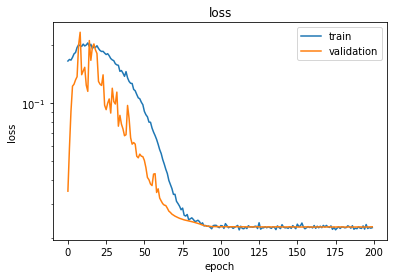

In [ ]:
# Plot training curve for loss
plt.plot(train_losses[:])
plt.plot(val_losses[:])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()

In [ ]:
# Load test dataset
testing_data = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/twenty_test_data.npz', allow_pickle=True)
test_data = testing_data['arr_0'] 

# Reorganises the array into input and label arrays, same as for training and validation sets
test_X = []
test_Y = []

for i in range (len(test_data)):
  test_X.append(test_data[i][0])
  test_Y.append(test_data[i][1])

test_X = np.array(test_X)
test_Y = np.array(test_Y)

# Adds axis to create correct array shape
test_X = test_X[:, :, :, np.newaxis]

print(test_X.shape, test_Y.shape)

# Standardise data for vgg
scaler = preprocessing.StandardScaler()
test_Y = scaler.fit_transform(np.squeeze(test_Y))
print(test_Y.shape)

# # Repeat along 3 dimensions to replicate RGB for vgg
test_Y = np.repeat(test_Y[:, np.newaxis, :], 3, axis=1)

# Make array >32 pixels high for vgg
test_Y = np.repeat(test_Y[:, :, :, np.newaxis], 3, axis=2)
print(test_Y.shape)

test_X = np.reshape(test_X, (-1,1,23,230,5))
test_Y = np.reshape(test_Y, (-1,3, 33, 10))
test_Y = np.repeat(test_Y[:, :, :, :], 4, axis=3)

print(test_X.shape, test_Y.shape)


(720, 23, 115, 1) (720, 11, 1)
(720, 11)
(720, 3, 33, 1)
(72, 1, 23, 230, 5) (72, 3, 33, 40)


In [ ]:
# PyTorch uses tensors
x_test, y_test = map(torch.tensor, (test_X, test_Y))

# Data must be stored on GPU to use GPU for training
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
x_test, y_test = x_test.to(dev), y_test.to(dev)


print(x_test.shape)

x_test, y_test = preprocess(x_test, y_test)
print(x_test.shape, y_test.shape)

torch.Size([72, 1, 23, 230, 5])
torch.Size([72, 1, 5, 23, 230]) torch.Size([72, 3, 33, 40])


In [ ]:
print("Generate predictions using the testing dataset")
predictions = cnn(x_test)

print(predictions.shape)

predictions = torch.reshape(predictions, (-1,33,40)).unsqueeze(1)
predictions = predictions.repeat(1,3,1,1)

y_test = np.squeeze(y_test)

test_error = nrmse_loss(predictions, y_test).item()

print('Test RMSE: {}'.format(test_error))

Generate predictions using the testing dataset
torch.Size([72, 1320])
Test RMSE: 0.052236590534448624


In [ ]:
predictions = predictions.cpu().detach().numpy()
y_test = y_test.cpu().detach().numpy()

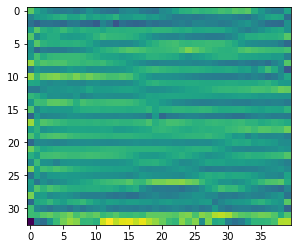

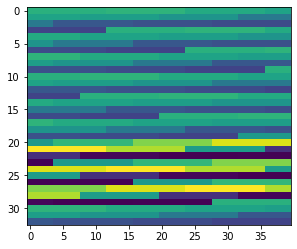

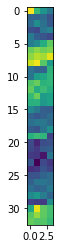

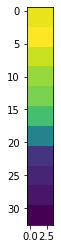

In [ ]:
plt.imshow(predictions[0, 0, :, :])
plt.show()
plt.imshow(y_test[0, 0, :, :])
plt.show()

pred = np.reshape(predictions, (-1, 3, 33, 4))
plt.imshow(pred[0, 0, :, :])
plt.show()

y = np.reshape(y_test, (-1, 3, 33, 4))
plt.imshow(y[0, 0, :, :])
plt.show()

In [ ]:
print(predictions.shape)
predictions = np.reshape(predictions, (-1, 3, 33, 4))
predictions = predictions[:, 0, [i for i in range(0,33,3)], 0]
print(predictions.shape)

print(test_Y.shape)
test_Y = np.reshape(test_Y, (-1, 3, 33, 4))
test_Y = test_Y[:, 0, [i for i in range(0,33,3)], 0]
print(test_Y.shape)

(72, 3, 33, 40)
(720, 11)
(72, 3, 33, 40)
(720, 11)


Predicted labels:


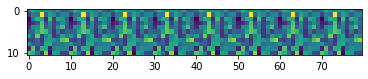

Real labels:


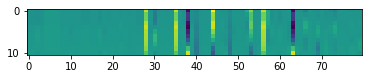

In [ ]:
print("Predicted labels:")
a = predictions[:80, ]
a = np.rot90(a)
plt.imshow(a)
plt.show()

print("Real labels:")
b = test_Y[:80, ]
b = np.rot90(b)
plt.imshow(b)
plt.show()

In [ ]:
# Loads the entire dataset of both blank and wave inputs/labels
norm_inputs = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/norm_inputs.npz', allow_pickle=True)
norm_labels = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/norm_labels.npz', allow_pickle=True)

norm_inputs = norm_inputs['arr_0']
print(norm_inputs.shape)

norm_labels = norm_labels['arr_0']
print(norm_labels.shape)

#Append the normalised input images for 1 complete image to a new array
one_img = []
one_lab = []
#top row: 100% blank purple images
for i in range (50, 18550, 53): # range reflects how data was organised in 'DatasetCreator_Cosima' notebook
  one_img.append(norm_inputs[i])
  one_lab.append(norm_labels[i])
print(np.array(one_img).shape, np.array(one_lab).shape)

#right column: 100% blank purple images
for i in range (18550+50, 43990, 53):
  one_img.append(norm_inputs[i])
  one_lab.append(norm_labels[i])
print(np.array(one_img).shape, np.array(one_lab).shape)

#left column: coloured wave images
for i in range (43990+50, 69430, 53):
  one_img.append(norm_inputs[i])
  one_lab.append(norm_labels[i])
print(np.array(one_img).shape, np.array(one_lab).shape)

#bottom row: 100% blank purple images
for i in range (69430+50, 87980, 53):
  one_img.append(norm_inputs[i])
  one_lab.append(norm_labels[i])
print(np.array(one_img).shape, np.array(one_lab).shape)

one_img = np.array(one_img) # one_img has 1 entire 350x480 image data in it
one_lab = np.array(one_lab)

one_img = one_img[:, :, :, np.newaxis]
print(one_img.shape, one_lab.shape) 

one_img = np.reshape(one_img, (-1,1,23,23,5))
print(one_img.shape)

# Standardise data for vgg
one_lab = scaler.fit_transform(np.squeeze(one_lab))
print(one_lab.shape)

# # Repeat along 3 dimensions to replicate RGB for vgg
one_lab = np.repeat(one_lab[:, np.newaxis, :], 3, axis=1)

# Make array >32 pixels high for vgg
one_lab = np.repeat(one_lab[:, :, :, np.newaxis], 3, axis=2)
print(one_lab.shape)

one_img = np.reshape(one_img, (-1,1,23,230,5))
one_lab = np.reshape(one_lab, (-1,3, 33, 10))
one_lab = np.repeat(one_lab[:, :, :, :], 4, axis=3)

print(one_img.shape, one_lab.shape)


(87980, 23, 115)
(87980, 11, 1)
(350, 23, 115) (350, 11, 1)
(830, 23, 115) (830, 11, 1)
(1310, 23, 115) (1310, 11, 1)
(1660, 23, 115) (1660, 11, 1)
(1660, 23, 115, 1) (1660, 11, 1)
(1660, 1, 23, 23, 5)
(1660, 11)
(1660, 3, 33, 1)
(166, 1, 23, 230, 5) (166, 3, 33, 40)


In [ ]:
# PyTorch uses tensors
one_img, one_lab = map(torch.tensor, (one_img, one_lab))

# Data must be stored on GPU to use GPU for training
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
one_img, one_lab = one_img.to(dev), one_lab.to(dev)

print(one_img.shape)
print(one_lab.shape)

one_img, one_lab = preprocess(one_img, one_lab)
print(one_img.shape)

torch.Size([166, 1, 23, 230, 5])
torch.Size([166, 3, 33, 40])
torch.Size([166, 1, 5, 23, 230])


In [ ]:
print("Generate predictions for 1 set of borders")

predictions2 = torch.reshape(cnn(one_img), (-1,33,40)).unsqueeze(1).repeat(1,3,1,1)

one_lab = np.squeeze(one_lab)

image_error = nrmse_loss(predictions2, one_lab).item()

print('Image RMSE: {}'.format(image_error))

Generate predictions for 1 set of borders
Image RMSE: 0.04969591274857521


In [ ]:
predictions2 = predictions2.cpu().detach().numpy()
one_lab = one_lab.cpu().detach().numpy()

(166, 3, 33, 40)
(1660, 11)
(166, 3, 33, 40)
(1660, 11)
Predicted Top Row:


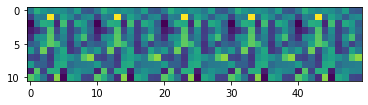

Real Top Row:


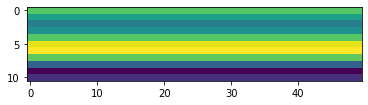

In [ ]:
print(predictions2.shape)
predictions2 = np.reshape(predictions2, (-1, 3, 33, 4))
predictions2 = predictions2[:, 0, [i for i in range(0,33,3)], 0]
print(predictions2.shape)

print(one_lab.shape)
one_lab = np.reshape(one_lab, (-1, 3, 33, 4))
one_lab = one_lab[:, 0, [i for i in range(0,33,3)], 0]
print(one_lab.shape)


# Top row 350 wide, showing first 50 labels to see the differences up close
print("Predicted Top Row:")
a = predictions2[0:50, :]
b = np.rot90(a)
plt.imshow(b)
plt.show()

print("Real Top Row:")
c = one_lab[0:50, :]
d = np.rot90(c)
plt.imshow(d)
plt.show()

In [ ]:
# Left column
print("Predicted Left Column:")
e = predictions2[830:1310, :]
e = np.rot90(e)
# e = np.flip(e, 1)
plt.imshow(e)
plt.show()

print("Real Left Column:")
g = one_lab[830:1310, :]
g = np.rot90(g)
plt.imshow(g)
plt.show()

In [ ]:
# Checking the differences between predicted and real images to make sure they are the same for blank and wave images
diff_blank = predictions2[0:350, :] - one_lab[0:350, :]
diff_blank = np.rot90(diff_blank)
plt.imshow(diff_blank)
plt.show()

diff_wave = predictions2[830:1310, :] - one_lab[830:1310, :]
diff_wave = np.rot90(diff_wave)
plt.imshow(diff_wave)
plt.show()

In [ ]:
# Predicted
# Get corresponding predicted parts for each border
top = predictions2[0:350, :]
top = np.rot90(top)
left = predictions2[830:1310, :]
right = predictions2[350:830, :]
bottom = predictions2[1310:1660, :]
bottom = np.rot90(bottom)

# Check their shapes
print('Predicted: top:', top.shape, 'left:', left.shape, 'right:', right.shape, 'bottom:', bottom.shape)

# Create empty array of desired rectangle size
pred_image_out = np.zeros((502, 350))

# Save each border into the rectangle
pred_image_out[0:11, 0:350] = top
pred_image_out[11:491, 339:350] = right
pred_image_out[491:502, 0:350] = bottom
pred_image_out[11:491, 0:11] = left

# Real
# Get corresponding real parts for each border
top = one_lab[0:350, :]
top = np.rot90(top)
left = one_lab[830:1310, :]
right = one_lab[350:830, :]
bottom = one_lab[1310:1660, :]
bottom = np.rot90(bottom)

# Check their shapes
print('Real: top:', top.shape, 'left:', left.shape, 'right:', right.shape, 'bottom:', bottom.shape)

# Create empty array of desired rectangle size
real_image_out = np.zeros((502, 350))

# Save each border into the rectangle
real_image_out[0:11, 0:350] = top
real_image_out[11:491, 339:350] = right
real_image_out[491:502, 0:350] = bottom
real_image_out[11:491, 0:11] = left

In [ ]:
# Plot images
print('Predicted:')
plt.imshow(pred_image_out)
plt.show()

print('Real:')
plt.imshow(real_image_out)
plt.show()